<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

Wikishop online store launches a new service. Now users can edit and add product descriptions, just like in wiki communities. That is, clients offer their own edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation. 

Train the model to classify comments into positive and negative ones. You have at your disposal a data set with markup on the toxicity of edits.

Build a model with the value of the quality metric *F1* at least 0.75.

**Description of the data**

The data is in the file `toxic_comments.csv'. The *text* column in it contains the text of the comment, and *toxic* is the target attribute.

# Project for «Wikishop»

## Preparation

In [1]:
import pandas as pd 
import numpy as np 

from sklearn.pipeline import Pipeline

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score

import time
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.nunique()

Unnamed: 0    159292
text          159292
toxic              2
dtype: int64

The data consists of two columns: 'text' contains the text of the comment, 'toxic' - the target attribute. There are no duplicates or missing values. Consider the distribution of the target feature:

<AxesSubplot:>

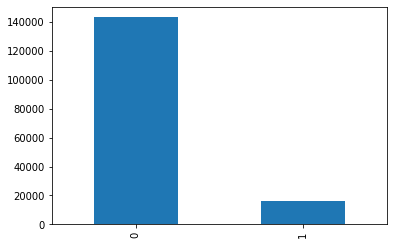

In [8]:
data['toxic'].value_counts().plot(kind='bar')

So, a preliminary analysis of the data showed that it:
* 159292 lines
* There are no duplicates or omissions
* 2 columns: toxic, text
* The text column contains the texts of the tweets
* Toxic tweets are marked in the toxic column
* 90% of tweets are non-toxic

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [10]:
%%time
data['text'] = data['text'].map(lambda x: clean_text(x))

CPU times: user 7.48 s, sys: 95.9 ms, total: 7.58 s
Wall time: 7.59 s


The data was processed from unnecessary characters: unnecessary omissions, html tags, single characters, including at the beginning of the line.

## Training

Let's split the data into training and test samples:

In [11]:
features = data['text']
target = data['toxic']
RANDOM_STATE = 12345
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

Let's upload stop words:

In [12]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's create a counter by specifying stop words in it:

In [13]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Then we'll count TD-IDF:

In [14]:
tf_idf = count_tf_idf.fit(features_train)

Now we'll create features:

In [15]:
features_train = tf_idf.transform(features_train)
features_test = tf_idf.transform(features_test)

Let's create a function for training models, searching for f1 and the best hyperparameters:

In [16]:
def model_look (model, parameters, features, target):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring='f1', verbose=5)
    model_grid.fit(features, target)
    return model_grid.best_score_, model_grid.best_params_

### LogisticRegression

In [17]:
parameters = {'C': range(23, 26, 1), 'max_iter': range(8, 10, 1)}
f1, best_parameters = model_look (LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'), parameters, features_train, target_train)
display('Best parameters', best_parameters)
display('F1 of a model:', f1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...............................C=23, max_iter=8; total time=   5.3s
[CV 2/5] END ...............................C=23, max_iter=8; total time=   5.3s
[CV 3/5] END ...............................C=23, max_iter=8; total time=   5.2s
[CV 4/5] END ...............................C=23, max_iter=8; total time=   5.3s
[CV 5/5] END ...............................C=23, max_iter=8; total time=   5.2s
[CV 1/5] END ...............................C=23, max_iter=9; total time=   5.8s
[CV 2/5] END ...............................C=23, max_iter=9; total time=   5.9s
[CV 3/5] END ...............................C=23, max_iter=9; total time=   5.6s
[CV 4/5] END ...............................C=23, max_iter=9; total time=   5.8s
[CV 5/5] END ...............................C=23, max_iter=9; total time=   5.9s
[CV 1/5] END ...............................C=24, max_iter=8; total time=   5.3s
[CV 2/5] END ...............................C=24,

'Best parameters'

{'C': 25, 'max_iter': 8}

'F1 of a model:'

0.7643145224279749

In [18]:
results = pd.DataFrame ({'model':['LogisticRegression'], 'best_parameters_train':[best_parameters], 'f1_train':[f1]})
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.764315


### DecisionTree

In [19]:
parameters = {'max_depth': range(122, 124, 1)}
f1, best_parameters = model_look (DecisionTreeClassifier(random_state=RANDOM_STATE), parameters, features_train, target_train)
display('Best parameters:', best_parameters)
display('F1 of a model:', f1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..................................max_depth=122; total time=  50.8s
[CV 2/5] END ..................................max_depth=122; total time=  50.7s
[CV 3/5] END ..................................max_depth=122; total time=  50.6s
[CV 4/5] END ..................................max_depth=122; total time=  50.1s
[CV 5/5] END ..................................max_depth=122; total time=  50.5s
[CV 1/5] END ..................................max_depth=123; total time=  51.1s
[CV 2/5] END ..................................max_depth=123; total time=  50.8s
[CV 3/5] END ..................................max_depth=123; total time=  50.4s
[CV 4/5] END ..................................max_depth=123; total time=  50.1s
[CV 5/5] END ..................................max_depth=123; total time=  50.4s


'Best parameters:'

{'max_depth': 123}

'F1 of a model:'

0.7221519982465496

In [20]:
results = results.append({'model':'DecisionTreeClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.764315
1,DecisionTreeClassifier,{'max_depth': 123},0.722152


### RandomForest

In [21]:
parameters = {'max_depth': range(213, 216, 1), 'n_estimators': range(3, 6, 1)}
f1, best_parameters = model_look (RandomForestClassifier(random_state=RANDOM_STATE), parameters, features_train, target_train)
display('Best parameters:', best_parameters)
display('F1 of a model:', f1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..................max_depth=213, n_estimators=3; total time=  12.2s
[CV 2/5] END ..................max_depth=213, n_estimators=3; total time=  12.2s
[CV 3/5] END ..................max_depth=213, n_estimators=3; total time=  12.6s
[CV 4/5] END ..................max_depth=213, n_estimators=3; total time=  12.5s
[CV 5/5] END ..................max_depth=213, n_estimators=3; total time=  11.9s
[CV 1/5] END ..................max_depth=213, n_estimators=4; total time=  16.4s
[CV 2/5] END ..................max_depth=213, n_estimators=4; total time=  16.7s
[CV 3/5] END ..................max_depth=213, n_estimators=4; total time=  16.8s
[CV 4/5] END ..................max_depth=213, n_estimators=4; total time=  16.5s
[CV 5/5] END ..................max_depth=213, n_estimators=4; total time=  16.4s
[CV 1/5] END ..................max_depth=213, n_estimators=5; total time=  20.4s
[CV 2/5] END ..................max_depth=213, n_e

'Best parameters:'

{'max_depth': 215, 'n_estimators': 4}

'F1 of a model:'

0.5559801829555623

In [22]:
results = results.append({'model':'RandomForestClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 25, 'max_iter': 8}",0.764315
1,DecisionTreeClassifier,{'max_depth': 123},0.722152
2,RandomForestClassifier,"{'max_depth': 215, 'n_estimators': 4}",0.555980


### CatBoostClassifier

In [ ]:
parameters = {'iterations': range(1000, 1200, 100)}
f1, best_parameters = model_look (CatBoostClassifier(random_state=RANDOM_STATE), parameters, features_train, target_train)
display('Best parameters:', best_parameters)
display('F1 of a model:', f1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Learning rate set to 0.072201
0:	learn: 0.6182917	total: 2.57s	remaining: 42m 46s
1:	learn: 0.5563423	total: 4.51s	remaining: 37m 31s
2:	learn: 0.5049673	total: 6.37s	remaining: 35m 18s
3:	learn: 0.4623477	total: 8.2s	remaining: 34m 2s
4:	learn: 0.4262664	total: 10.1s	remaining: 33m 24s
5:	learn: 0.3973694	total: 12s	remaining: 33m 2s
6:	learn: 0.3729732	total: 13.8s	remaining: 32m 43s
7:	learn: 0.3509088	total: 15.8s	remaining: 32m 33s
8:	learn: 0.3332855	total: 17.6s	remaining: 32m 20s
9:	learn: 0.3181264	total: 19.5s	remaining: 32m 15s
10:	learn: 0.3051962	total: 21.4s	remaining: 32m 7s
11:	learn: 0.2942701	total: 23.3s	remaining: 32m 2s
12:	learn: 0.2852350	total: 25.3s	remaining: 32m 1s
13:	learn: 0.2774701	total: 27.2s	remaining: 31m 57s
14:	learn: 0.2704792	total: 29.1s	remaining: 31m 51s
15:	learn: 0.2648528	total: 31s	remaining: 31m 43s
16:	learn: 0.2593000	total: 32.9s	remaining: 31m 39s
17:	learn: 0.2545202	total: 3

In [ ]:
results = results.append({'model':'CatBoostClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

The data were trained by models, the best hyperparameters for them were identified and derived. Let's check the results on the test data.

Logistic regression has the best results, and we will check it on test data

Let's create a model training function on a test sample, taking into account the entry of the result of the f1 metric into the table:

In [ ]:
def ml_result(model, features_train, target_train, features_test, target_test):
        
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_test)
    
    f1 = f1_score(target_test, predictions)
      
    return f1

Let's test the logistic regression model on a test set:

In [ ]:
f1 = ml_result(LogisticRegression(
    random_state=RANDOM_STATE, solver='liblinear', C=24, max_iter=8), features_train, target_train, features_test, target_test
              )
results.loc[0, 'f1_test'] = f1
results

## Conclusions

* Machine learning models were trained on training data and then tested on a test sample
* The models that got the best results turned out to be Logistic Regression and CatBoostClassifier
* However, more accurate predictions and shorter training time can be noted in Logistic Regression
* The best parameters of the Logistic Regression model in the training sample: 'C': 25, 'max_iter': 8,'F1 models:'0.7643145224279749